### Project Overview

1. **Preprocessing Images**:
   - The images in the dataset come in different sizes. We will preprocess them by cropping to dimensions divisible by 256 to ensure uniformity.

2. **Handling Mask Colors**:
   - The mask images contain HEXA codes that need to be converted to RGB format for proper representation.

3. **One-Hot Encoding**:
   - Since this is a multi-class segmentation problem, we will convert the RGB values into one-hot encoded format for model training.

4. **Reconversion of Predicted Images**:
   - After prediction, the images will need to be converted back to their original RGB colors.

We will use the **patchify** library for image cropping and extracting patches. The patch size will be (256, 256), meaning we need to divide the original images into tiles of (n_rows, n_cols) that are divisible by 256.

The **U-Net architecture** will be implemented for this segmentation problem using TensorFlow's Keras API.


In [1]:
# Importing required libraries
# Standard libraries
import os 
from pathlib import Path
from patchify import patchify
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# TensorFlow and Keras libraries
import tensorflow
import keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import (
    Input, 
    Conv2D, 
    BatchNormalization, 
    ReLU, 
    SpatialDropout2D, 
    MaxPooling2D, 
    Conv2DTranspose, 
    concatenate
)

# Metrics and Loss functions
from tensorflow.keras.metrics import OneHotIoU, Recall, Precision
from tensorflow.keras.losses import CategoricalFocalCrossentropy, Dice
from tensorflow.keras.callbacks import ModelCheckpoint


2024-10-22 16:26:29.743030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the directory containing the dataset
directory = Path('data/raw/')
scaler = MinMaxScaler()
patch_size = 256
image_dataset = []

# Walk through the directory to find images
for path in directory.glob('**/images'):
    images = sorted(path.glob('*.jpg'))  
    print(f'Found images in: {path.name}')
    print([img.name for img in images])
    
    for image_path in images:
        image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
        
        if image is None:
            print(f'Error loading image: {image_path}')
            continue  
        
        # Resize the image to be divisible by the patch size
        x_size = (image.shape[1] // patch_size) * patch_size
        y_size = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image).crop((0, 0, x_size, y_size))
        image = np.array(image)

        # Extract patches from each image with overlap
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

        # Normalize each patch and append to dataset
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                # Drop the extra unnecessary dimension that patchify adds
                single_patch_img = single_patch_img[0]
                image_dataset.append(single_patch_img)


Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.j

In [3]:
# Define the patch size and initialize the mask dataset
patch_size = 256
mask_dataset = []

# Walk through the directory to find masks
for path in directory.glob('**/masks'):
    masks = sorted(path.glob('*.png'))  
    print(f'Found masks in: {path.name}')
    print([mask.name for mask in masks])

    for mask_path in masks:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_COLOR)

        if mask is None:
            print(f'Error loading mask: {mask_path}')
            continue  

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        x_size = (mask.shape[1] // patch_size) * patch_size
        y_size = (mask.shape[0] // patch_size) * patch_size
        mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))
        mask = np.array(mask)

        # Extract patches from each mask with overlap
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

        # Append each single patch to the mask dataset
        for row in range(patches_mask.shape[0]):
            for col in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[row, col, :, :]

                # Drop the extra unnecessary dimension that patchify adds
                single_patch_mask = single_patch_mask[0]
                mask_dataset.append(single_patch_mask)


Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'imag

In [4]:
print(len(image_dataset), len(mask_dataset))

1305 1305


In [5]:
#converting the image and masks lists into arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Print shapes of the datasets
print(image_dataset.shape, mask_dataset.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


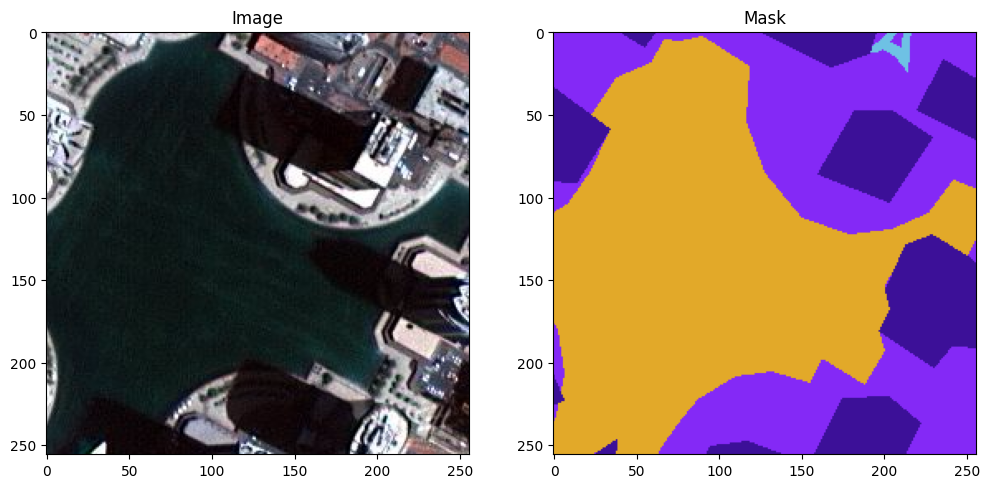

In [6]:
# Check the consistency between the images and masks 
check_number = np.random.randint(0, len(image_dataset))

# Create a figure to display the selected image and its corresponding mask
fig = plt.figure(figsize=(12, 10))
ax = fig.subplot_mosaic("""AB""")
ax['A'].imshow(image_dataset[check_number])
ax['A'].set_title('Image')
ax['B'].imshow(mask_dataset[check_number])
ax['B'].set_title('Mask')
plt.show()

In [7]:
# Define hexadecimal colors for each class
class_colors_hex = {
    'Building': '#3C1098',
    'Land': '#8429F6',
    'Road': '#6EC1E4',
    'Vegetation': '#FEDD3A',
    'Water': '#E2A929',
    'Unlabeled': '#9B9B9B'
}

# Function to convert hexadecimal colors to RGB integer values
def hex_to_int(hex_color):
    hex_color = hex_color.lstrip('#')  # Remove the '#' from the beginning
    return np.array(tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))  # Convert to RGB

# Create a dictionary mapping class names to their RGB integer values
class_colors = {key: hex_to_int(value) for key, value in class_colors_hex.items()}

# Print the RGB values for each class
print(class_colors)


{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [8]:
# Function to convert RGB colors in the label masks to integer labels
def rgb_to_2D_label(label):
    """
    Convert RGB mask to integer labels based on predefined class colors.

    Args:
        label (np.ndarray): Input mask in RGB format.

    Returns:
        np.ndarray: Segmentation mask with integer labels.
    """
    # Initialize a label mask with zeros
    label_seg = np.zeros(label.shape[:-1], dtype=np.uint8)
    
    # Assign integer labels based on RGB values
    for idx, color in enumerate(class_colors.values()):
        label_seg[np.all(label == color, axis=-1)] = idx  # Match the color

    return label_seg

# Convert all masks in mask_dataset to integer labels
labels = np.array([rgb_to_2D_label(mask) for mask in mask_dataset])  # Process each mask
print(labels.shape)
labels = np.expand_dims(labels, axis=3)  # Add an extra dimension

# Display unique labels and the shape of the labels array
print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of the labels is: ", labels.shape)


(1305, 256, 256)
Unique labels in label dataset are:  [0 1 2 3 4 5]
Shape of the labels is:  (1305, 256, 256, 1)


In [9]:
# Converting labels to categories using one-hot encoding
num_classes = len(class_colors)  
labels_categ = to_categorical(labels, num_classes=num_classes) 

# Display the shape of the one-hot encoded labels
print("Shape of one-hot encoded labels:", labels_categ.shape)

Shape of one-hot encoded labels: (1305, 256, 256, 6)


In [10]:
# Splitting the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_categ, test_size=0.20, random_state=42)

# Further splitting the test data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Outputting the shapes of each split
print(f'Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape of validation data: X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'Shape of test data: X_test: {X_test.shape}, y_test: {y_test.shape}')


Shape of training data: X_train: (1044, 256, 256, 3), y_train: (1044, 256, 256, 6)
Shape of validation data: X_val: (130, 256, 256, 3), y_val: (130, 256, 256, 6)
Shape of test data: X_test: (131, 256, 256, 3), y_test: (131, 256, 256, 6)


In [11]:
# Data Augmentation
# Creating the data generators with specified augmentation parameters
batch_size = 32

data_gen_args = dict(
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Instantiate ImageDataGenerator for images and labels
image_data_gen = ImageDataGenerator(**data_gen_args)
label_data_gen = ImageDataGenerator(**data_gen_args)

def data_generator(image_data_gen, label_data_gen, X_train, y_train, batch_size):
    """
    Generator function that yields batches of augmented image and label data.

    Parameters:
    - image_data_gen: Augmentation configuration for images.
    - label_data_gen: Augmentation configuration for labels.
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of samples per batch.

    Yields:
    - Tuple of augmented image and label batches.
    """
    # Create generators for images and labels
    image_generator = image_data_gen.flow(X_train, batch_size=batch_size, seed=42)
    label_generator = label_data_gen.flow(y_train, batch_size=batch_size, seed=42)

    while True:
        # Get the next batch of images and labels
        X_batch = next(image_generator)
        y_batch = next(label_generator)

        yield X_batch, y_batch

# Initialize the training generator
train_generator = data_generator(image_data_gen, label_data_gen, X_train, y_train, batch_size)


In [12]:
'''
Experimentation Summary:
- Used `he_normal` for weight initialization: Resulted in faster convergence than `xavier_uniform`.
- Tried dropout and spatial dropout: Spatial dropout performed better, but the overall results were better without any dropout.
'''

def custom_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    """
    Builds a U-Net model for semantic segmentation.

    Parameters:
    n_classes (int): Number of output classes for segmentation.
    IMG_HEIGHT (int): Height of the input image.
    IMG_WIDTH (int): Width of the input image.
    IMG_CHANNELS (int): Number of channels in the input image.

    Returns:
    model (keras.Model): Compiled U-Net model.
    """
    # Input layer
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder path
    c0 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    c0 = BatchNormalization()(c0)
    c0 = ReLU()(c0)
    p0 = MaxPooling2D((2, 2))(c0)

    c1 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(p0)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # Bottleneck
    c6 = Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal')(p5)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)

    # Decoder path
    u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)

    u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)

    u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)

    u10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(u10)
    c10 = BatchNormalization()(c10)
    c10 = ReLU()(c10)

    u11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1])
    c11 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(u11)
    c11 = BatchNormalization()(c11)
    c11 = ReLU()(c11)

    u12 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c11)
    u12 = concatenate([u12, c0])
    c12 = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal')(u12)
    c12 = BatchNormalization()(c12)
    c12 = ReLU()(c12)

    # Output layer with softmax activation for multi-class segmentation
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c12)

    # Compile model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [13]:
# Display the model architecture
# It's important to check the structure of the U-Net model, layer connections, and total parameters
model = custom_unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ re_lu_3[0][0]   

 Total params: 15,392,102 (58.72 MB)

 Trainable params: 15,386,022 (58.69 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [14]:
# Defining Jaccard coefficient (Intersection over Union)
# This metric measures the overlap between the predicted and actual segmentation masks
def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred, axis=(-1))
    union = tensorflow.reduce_sum(y_true + y_pred, axis=(-1))
    jac = (intersection + smooth) / (union - intersection + smooth)
    return jac

# Metrics for model evaluation
# OneHotIoU measures the intersection over union for each class
metrics = [OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4,5]), Precision(), Recall(), jaccard_coeff]


In [15]:
# Initializing the focal loss with alpha and gamma to handle class imbalance
focal = CategoricalFocalCrossentropy(alpha=0.5, gamma=1)

# Dice loss focuses on overlap between predicted and true regions
dice = Dice()

# Combining dice and focal loss
def combined_dice_focal_loss(y_true, y_pred):
    dice_loss = dice(y_true, y_pred)
    focal_loss = focal(y_true, y_pred)
    total_loss = focal_loss + dice_loss
    return total_loss


In [16]:
from keras.callbacks import ModelCheckpoint
check_point = ModelCheckpoint('Unet.weights.h5', monitor='val_jaccard_coeff', mode='max', save_weights_only=True, save_best_only=True, verbose=1)

In [ ]:
# Compile the model
model.compile(optimizer= 'adam', loss= combined_dice_focal_loss, metrics= metrics)

# Train the model
history = model.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=150, validation_data=(X_val, y_val), callbacks=[check_point])


In [ ]:
def plot_training_history(history):
    # Extracting the history data
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mean_iou = history.history['one_hot_io_u']
    val_mean_iou = history.history['val_one_hot_io_u']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    jaccard_coef = history.history['jaccard_coeff']
    val_jaccard_coef = history.history['val_jaccard_coeff']
    
    epochs = range(1, len(loss) + 1)
    
    # Plotting
    plt.figure(figsize=(18, 12))
    
    # Plotting Jaccard Coefficient
    plt.subplot(3, 2, 1)
    plt.plot(epochs, jaccard_coef, 'b', label='Training Jaccard Coefficient')
    plt.plot(epochs, val_jaccard_coef, 'r', label='Validation Jaccard Coefficient')
    plt.title('Training and Validation Jaccard Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Coefficient')
    plt.grid()
    plt.legend()
    
    # Plotting Mean IoU
    plt.subplot(3, 2, 2)
    plt.plot(epochs, mean_iou, 'b', label='Training Mean IoU')
    plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.grid()
    plt.legend()
    
    # Plotting Precision
    plt.subplot(3, 2, 3)
    plt.plot(epochs, precision, 'b', label='Training Precision')
    plt.plot(epochs, val_precision, 'r', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.grid()
    plt.legend()
    
    # Plotting Recall
    plt.subplot(3, 2, 4)
    plt.plot(epochs, recall, 'b', label='Training Recall')
    plt.plot(epochs, val_recall, 'r', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.grid()
    plt.legend()
    
    # Plotting Loss
    plt.subplot(3, 2, 5)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('/semantic_segmentation/results/', format='png', dpi=300)
    plt.show()

# Call the function to plot the results
plot_training_history(history)


In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# Plot and compare predictions for 10 random samples
for i in range(10):
    index = np.random.randint(0, len(X_test))

    input_image = X_test[index]  
    true_mask_one_hot = y_test[index]    
    predicted_mask_one_hot = y_pred[index]  

    # Convert one-hot masks to integer masks
    true_mask = np.argmax(true_mask_one_hot, axis=-1)  
    predicted_mask = np.argmax(predicted_mask_one_hot, axis=-1)  

    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('tab20')  

    # Plot the input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title(f'Input Image {index}')
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap=cmap)
    plt.title(f'Predicted Mask {index}')
    plt.axis('off')

    # Plot the ground truth mask
    plt.subplot(1, 3, 3)
    plt.imshow(true_mask, cmap=cmap)
    plt.title(f'Ground Truth Mask {index}')
    plt.axis('off')

    # Ensure plots are spaced correctly
    plt.tight_layout()

    # Save the figure 
    plt.savefig(f'comparison_{index}.png', format='png', dpi=300)
    
    # Show the figure
    plt.show()
    

In [ ]:
# Save the model
model.save('Unet_model.h5')

In [30]:
from keras.models import load_model
custom_objects = {'combined_dice_focal_loss': combined_dice_focal_loss}

# Load the model
Unet_model = load_model('results/Unet_model.h5', custom_objects=custom_objects)

# Load the weights 
Unet_model.load_weights('results/Unet.weights.h5')

# Recompile the model 
Unet_model.compile(optimizer='adam', 
                   loss=combined_dice_focal_loss, 
                   metrics=metrics)  


/mnt/data1/my work/my projects/Satellite Images Semantic Segmentation/semantic_seg_venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 134 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# building a model using segmentation-models library

In [ ]:
# !pip install segmentation-models==1.0.1
# !pip install efficientnet==1.0.0

# # run this cell to make sure keras is compatible with segmentation_models 
# with open('/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py', 'r') as file:
#     file_data = file.readlines()

# # Modify the line that causes the error
# for i, line in enumerate(file_data):
#     if 'keras.utils.generic_utils.get_custom_objects().update(custom_objects)' in line:
#         file_data[i] = line.replace('keras.utils.generic_utils', 'keras.utils')

# with open('/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py', 'w') as file:
#     file.writelines(file_data)


# # Check
# file_path = '/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py'
# with open(file_path, 'r') as file:
#     file_data = file.readlines()

# # Search for 'generic_utils'
# found = False
# for line in file_data:
#     if 'generic_utils' in line:
#         found = True
#         print(f"'generic_utils' found in line: {line.strip()}")

# if not found:
#     print("No instances of 'generic_utils' found in the file.")


# import segmentation_models as sm
# from segmentation_models import Unet


# from segmentation_models import get_preprocessing
# BACKBONE = 'resnet18'
# preprocess_input = get_preprocessing(BACKBONE)

# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)


# # Load pre-trained U-Net model 
# base_model = Unet(BACKBONE, encoder_weights='imagenet', activation = 'softmax', classes=num_classes)

# compile and then train the model as usual 